## Cardiovascular Disease Bayesian Network

### Cardiovascular disease topic
Intro to cardiovascular deasease

### What's a Bayesian Network?
Sprazi di teoria

### Why a Bayesian Network?
Spiegare perché si è scelta

### Imports

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pgmpy.estimators import HillClimbSearch
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
import numpy as np

### Utils

In [44]:
def dataset_split(df, test_size=0.1):
    df = df.drop('id', axis=1)
    train_set, test_set = train_test_split(df, test_size=test_size)

    # save to csv
    test_set.to_csv('cardio_test_set.csv', index=False, sep=";")
    train_set.to_csv('cardio_train_set.csv', index=False, sep=";")

def draw_graphs(models, nrows=1, ncols=1, figsize=(15, 8)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i, model in enumerate(models):
        graph = nx.DiGraph()
        graph.add_edges_from(model.edges())
        nx.draw_networkx(graph, pos=nx.circular_layout(graph), with_labels=True, ax= axes if not isinstance(axes, np.ndarray) else axes[i])

    plt.show()

def print_bin_cat_distribution(df, cat_cols=["cholesterol", "gluc"], nrows=2, ncols=4, figsize=(25, 10)):
    binary_cols = ["gender", "smoke", "alco", "active", "cardio_disease"]
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(binary_cols + cat_cols):
        if col == "gender":
            sns.countplot(x=col, data=df, ax=axes[i])
            axes[i].set_xticklabels(["women", "men"])
        elif col == "cholesterol" or col == "gluc":
            sns.countplot(x=col, data=df, ax=axes[i])
            axes[i].set_xticklabels(["normal", "above normal", "well above normal"])
        else:
            sns.countplot(x=col, data=df, ax=axes[i])
            axes[i].set_xlabel(col)

def print_numeric_distribution(df, numeric_cols = ["age", "height", "weight", "ap_hi", "ap_lo"]):
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))
    axes = axes.flatten()
    for i, col in enumerate(numeric_cols):
        sns.boxplot(x=df[col], ax=axes[i])
        axes[i].set_xlabel(col)
    

### Dataset
Piccola intro sul dataset

In [3]:
df = pd.read_csv('cardio_dataset.csv', sep=';')

#### Dataset Analysis

##### Description

In [4]:
# Shows first dataframe rows
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [5]:
# 'age' column to years
df['age'] = (df['age'] / 365).astype(int)

# to int
df['weight'] = df['weight'].astype(int)

# renaming cardio in cardio_disease
df = df.rename(columns={'cardio': 'cardio_disease'})

In [6]:
df.describe().round(2)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio_disease
count,70000.00,70000.00,70000.00,70000.00,70000.0,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.0,70000.0
mean,49972.42,52.84,1.35,164.36,74.2,128.82,96.63,1.37,1.23,0.09,0.05,0.8,0.5
std,28851.30,6.77,0.48,8.21,14.4,154.01,188.47,0.68,0.57,0.28,0.23,0.4,0.5
min,0.00,29.00,1.00,55.00,10.0,-150.00,-70.00,1.00,1.00,0.00,0.00,0.0,0.0
25%,25006.75,48.00,1.00,159.00,65.0,120.00,80.00,1.00,1.00,0.00,0.00,1.0,0.0
50%,50001.50,53.00,1.00,165.00,72.0,120.00,80.00,1.00,1.00,0.00,0.00,1.0,0.0
75%,74889.25,58.00,2.00,170.00,82.0,140.00,90.00,2.00,1.00,0.00,0.00,1.0,1.0
max,99999.00,64.00,2.00,250.00,200.0,16020.00,11000.00,3.00,3.00,1.00,1.00,1.0,1.0


In [7]:
# Check null values
df.isnull().sum()

id                0
age               0
gender            0
height            0
weight            0
ap_hi             0
ap_lo             0
cholesterol       0
gluc              0
smoke             0
alco              0
active            0
cardio_disease    0
dtype: int64

##### Distribution Analysis

Numeric variable distribution

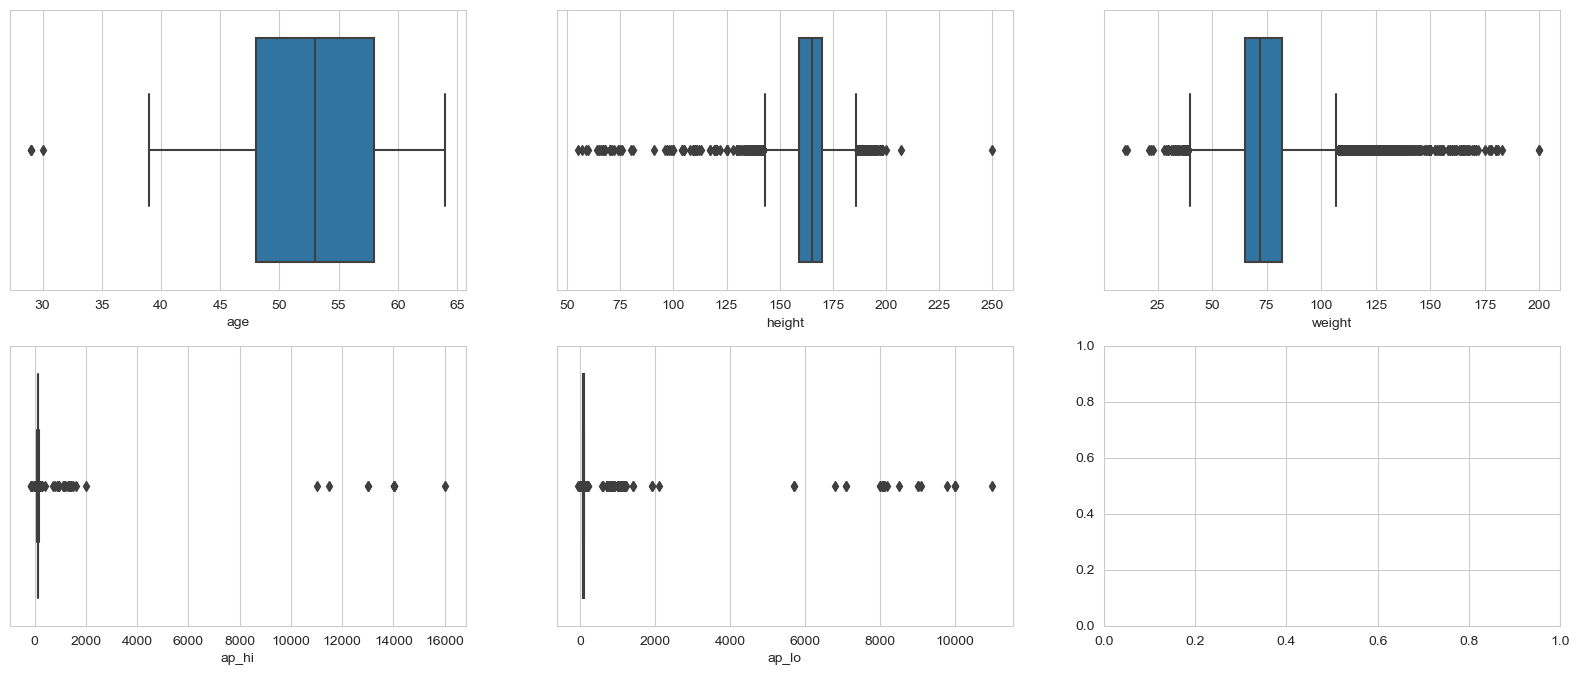

In [21]:
print_numeric_distribution(df)

As we can see above, there are several outliers that may influence the bayesian network, we are going to study it in the sections below

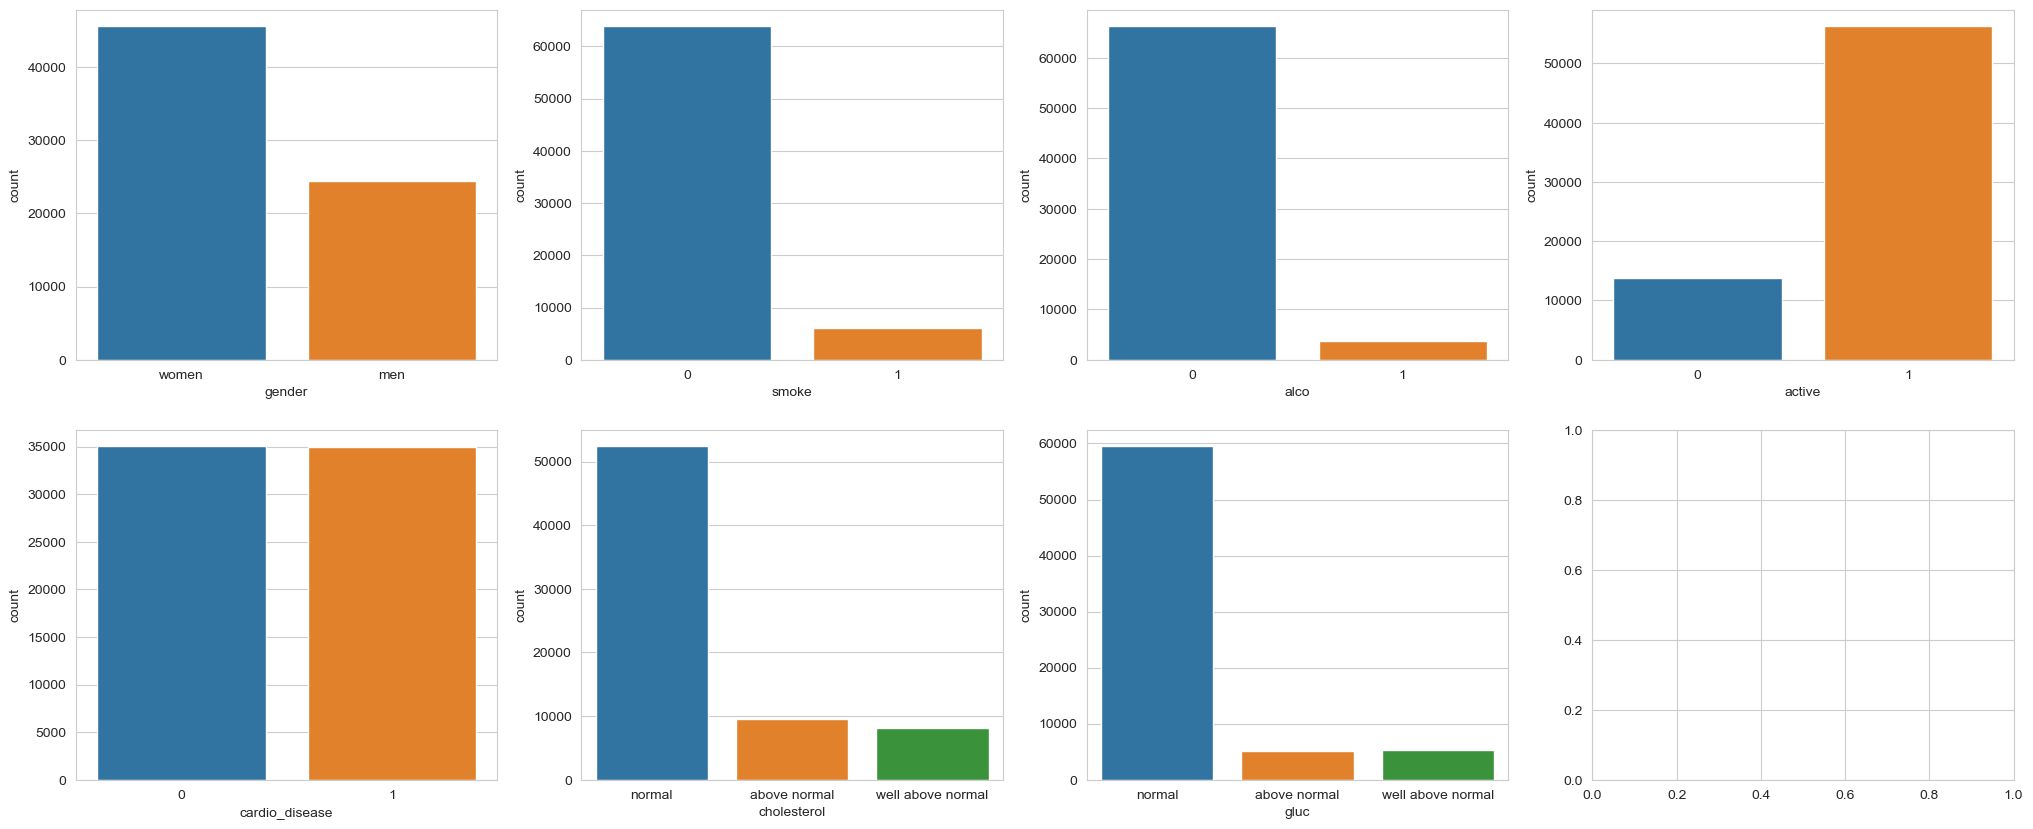

In [14]:
print_bin_cat_distribution(df)

##### Correlation Matrix

Check the correlation among variables through a Pearson correlation matrix heatmap.

Text(0.5, 1.0, 'Correlation Heatmap')

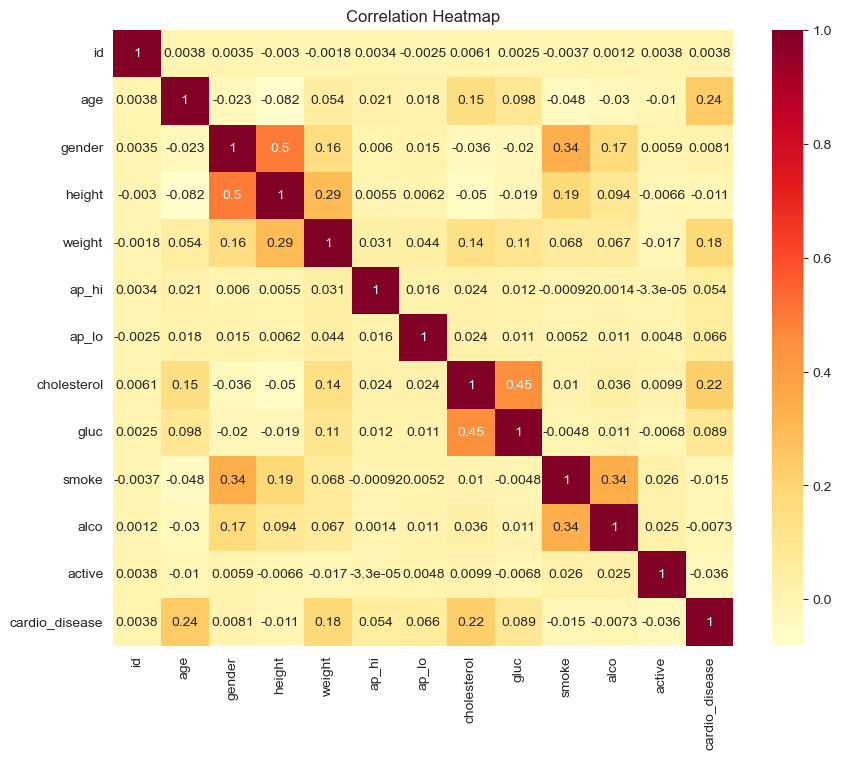

In [9]:
fig, ax = plt.subplots(figsize=(10, 8)) 
sns.heatmap(df.corr(), annot=True, ax=ax, cmap="YlOrRd")
plt.title("Correlation Heatmap")

From the above correlation heatmap, some pairs of variables with a positive correlation can be observed, such as:
- (age, cardio_disease)
- (gender, height)
- (gender, smoke)
- (height, weight)
- (weight, cardio_disease)
- (weight, ap_hi)
- (weight, ap_lo)
- (ap_hi, ap_lo)
- (ap_hi, cardio_disease)
- (ap_lo, cardio_disease)
- (cholesterol, gluc)
- (cholesterol, cardio_disease)
- (smoke, alco)

Therefore, there is a certain correlation between the variables, specifically in the case of cardiovascular diseases, a positive correlation is observed with increasing age, weight, ap_hight, ap_low, cholesterol, and partly with glucose.

### HillClimbSearch Algorithm

piccola spiegazione

In [81]:
def hill_climb_structural_learning(train_data, score_method): # score_method ["k2score", "bicscore"]
    hc = HillClimbSearch(train_data)
    best_model= hc.estimate(scoring_method=score_method)
    return best_model

def hill_climb_parameters_learning(best_model, train_data):
    model = BayesianNetwork(best_model.edges())
    model.fit(data=train_data, estimator=MaximumLikelihoodEstimator)
    return model

def accuracy(model):
    test_data = pd.read_csv('cardio_test_set.csv', sep=';')
    prediction_dataset = test_data.drop(["cardio_disease"], axis=1)
    y_pred = model.predict(prediction_dataset)
    y_true = test_data['cardio_disease'].values
    return accuracy_score(y_true, y_pred)

def inference(model, evidence):
    infer = VariableElimination(model)
    q = infer.query(variables=['cardio_disease'], evidence=evidence)
    return q

### MCMC Algorithm

### Study Case 1 - HillClimbSearch vs MCMC with Outliers

#### Split dataset into trainset and testset

In [72]:
dataset = df.copy()
dataset_split(dataset, test_size=0.1)
train_data = pd.read_csv('cardio_train_set.csv', sep=';')
test_data = pd.read_csv('cardio_test_set.csv', sep=';')

#### Check trainset distribution

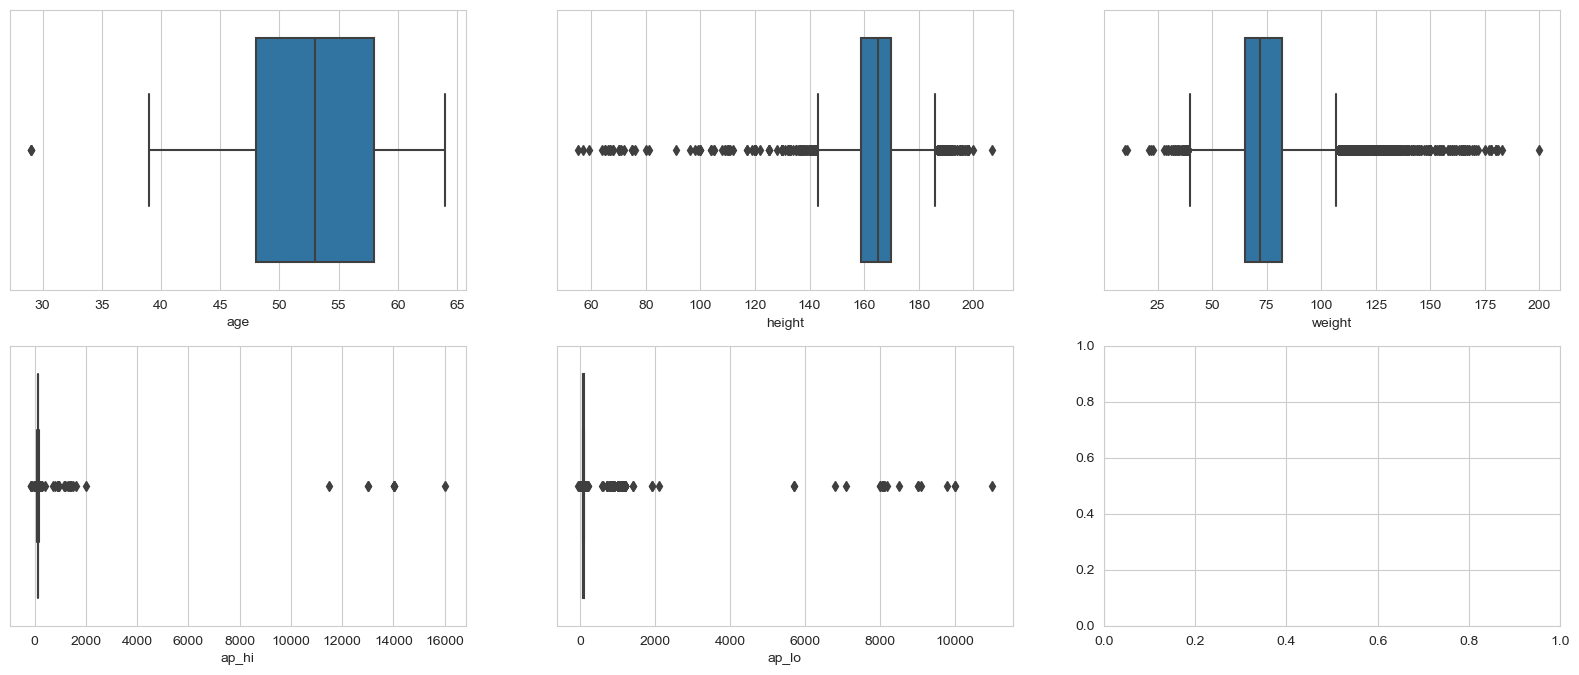

In [22]:
print_numeric_distribution(train_data)

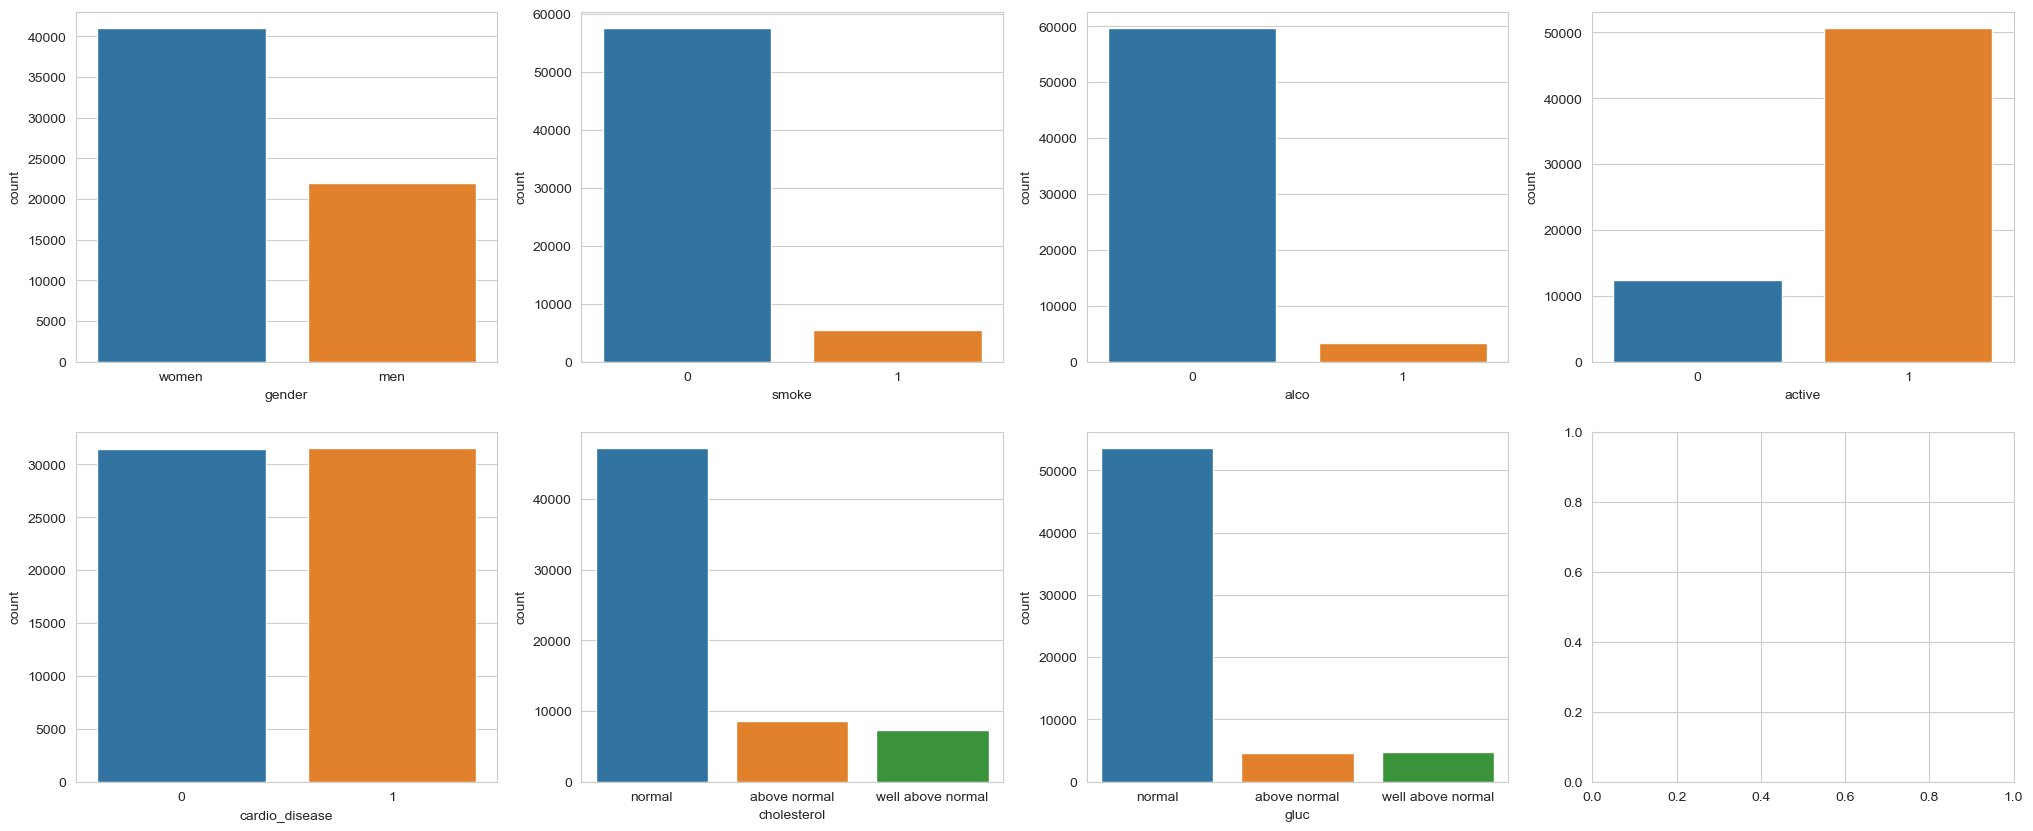

In [15]:
print_bin_cat_distribution(train_data)

#### HillClimbSearch

  0%|          | 0/1000000 [00:00<?, ?it/s]

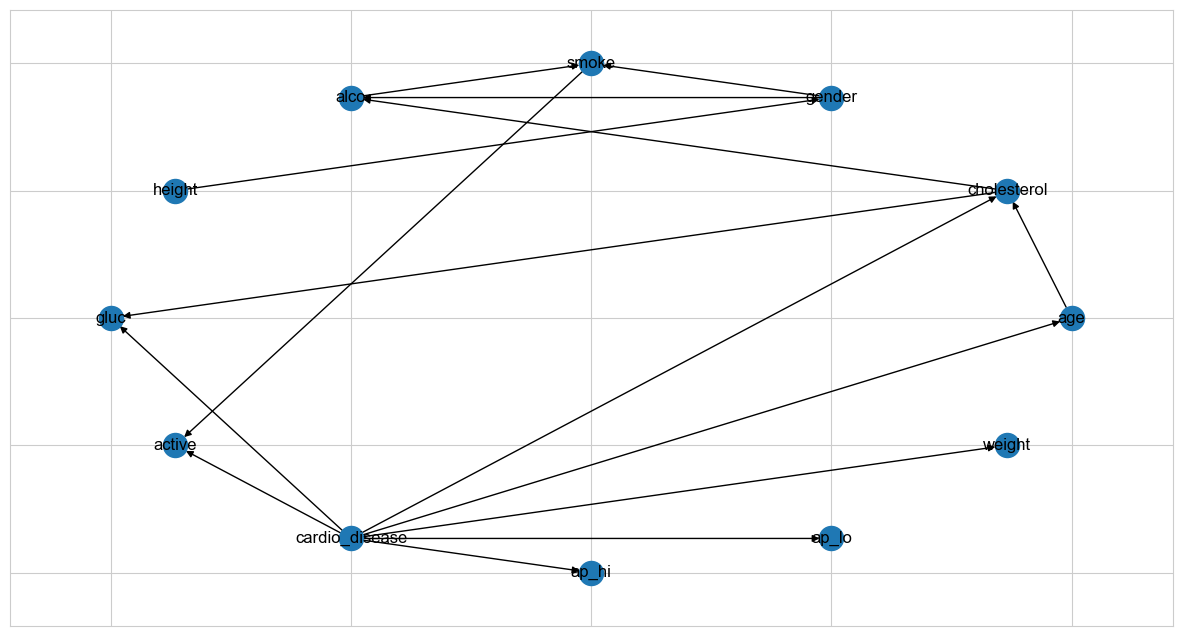

In [73]:
best_model = hill_climb_structural_learning(train_data, score_method="bicscore")
draw_graphs([best_model])

In [74]:
model = hill_climb_parameters_learning(best_model, train_data)
try:
    print(accuracy(model))
except Exception as e:
    print("Error:", e)

  0%|          | 0/6914 [00:00<?, ?it/s]

/Users/danilosantitto/miniconda3/lib/python3.10/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:541: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  warnings.warn(
/Users/danilosantitto/miniconda3/lib/python3.10/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:541: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  warnings.warn(
/Users/danilosantitto/miniconda3/lib/python3.10/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:541: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  warnings.warn(


Error: index 8200 is out of bounds for axis 0 with size 150


/Users/danilosantitto/miniconda3/lib/python3.10/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:541: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  warnings.warn(


The error is caused by unique outliers that the model encountered and did not know how to predict. This is also an indication that the hill climb model is overfitting.

In [75]:
q = inference(model, evidence= {'age': 60, 'gender': 2, 'height': 170, 'weight': 70, 'ap_hi': 120, 'ap_lo': 80, 'cholesterol': 1, 'gluc': 1, 'smoke': 0, 'alco': 0, 'active': 1})
print(q)

+-------------------+-----------------------+
| cardio_disease    |   phi(cardio_disease) |
+===================+=======================+
| cardio_disease(0) |                0.7256 |
+-------------------+-----------------------+
| cardio_disease(1) |                0.2744 |
+-------------------+-----------------------+


### Study Case 2 - HillClimbSearch vs MCMC without Outliers

#### Remove Outliers
The boxplots show the presence of several outliers. Considering the dataset of 70K samples, it is reasonable to assume that there are some exceptional cases related to physical conditions. Below, we use the Interquartile range (IQR) method to analyze and remove the outliers.

In [76]:
def outliers(df, feature):
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    ls = df.index[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    return ls

def remove(df, ls):
    ls = sorted(set(ls))
    df = df.drop(ls)
    return df

In [77]:
dataset = df.copy()
index_list = []
for feature in ["age", "height", "weight", "ap_hi", "ap_lo"]:
    index_list.extend(outliers(dataset, feature))

dataset = remove(dataset, index_list)
print("Number of outliers removed:", len(index_list))
print("Number of rows left:", len(dataset))

Number of outliers removed: 8409
Number of rows left: 62502


In [66]:
dataset.describe().round(2)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio_disease
count,62502.00,62502.00,62502.00,62502.00,62502.00,62502.00,62502.00,62502.00,62502.00,62502.00,62502.00,62502.0,62502.00
mean,49941.88,52.91,1.35,164.41,73.18,126.42,81.70,1.36,1.22,0.09,0.05,0.8,0.49
std,28864.47,6.74,0.48,7.53,12.27,14.29,7.67,0.68,0.57,0.28,0.22,0.4,0.50
min,0.00,39.00,1.00,143.00,40.00,90.00,65.00,1.00,1.00,0.00,0.00,0.0,0.00
25%,24876.50,48.00,1.00,159.00,65.00,120.00,80.00,1.00,1.00,0.00,0.00,1.0,0.00
50%,49980.50,54.00,1.00,165.00,72.00,120.00,80.00,1.00,1.00,0.00,0.00,1.0,0.00
75%,74848.75,58.00,2.00,170.00,81.00,140.00,90.00,1.00,1.00,0.00,0.00,1.0,1.00
max,99999.00,64.00,2.00,186.00,107.00,170.00,105.00,3.00,3.00,1.00,1.00,1.0,1.00


#### Split dataset into trainset and testset

In [78]:
dataset_split(dataset, test_size=0.1)
train_data = pd.read_csv('cardio_train_set.csv', sep=';')
test_data = pd.read_csv('cardio_test_set.csv', sep=';')

#### HillClimbSearch

  0%|          | 0/1000000 [00:00<?, ?it/s]

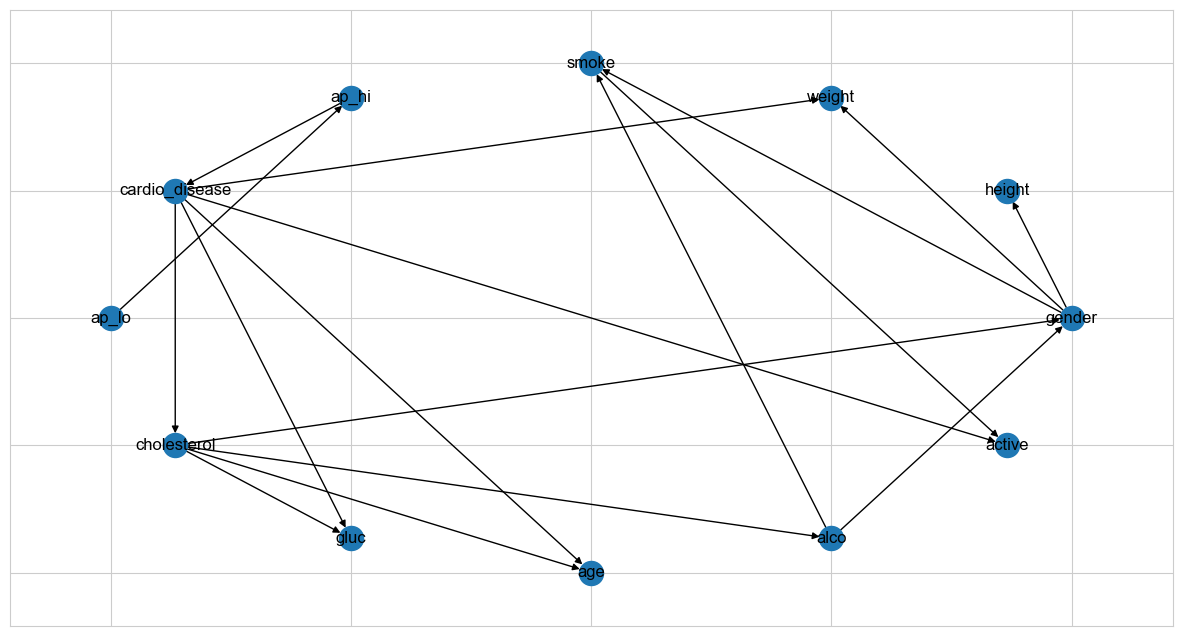

In [79]:
best_model = hill_climb_structural_learning(train_data, score_method="bicscore")
draw_graphs([best_model])

In [80]:
model = hill_climb_parameters_learning(best_model, train_data)
try:
    print(accuracy(model))
except Exception as e:
    print("Error:", e)

  0%|          | 0/6173 [00:00<?, ?it/s]

0.7296432570788673


The error is caused by unique outliers that the model encountered and did not know how to predict. This is also an indication that the hill climb model is overfitting.

In [82]:
q = inference(model, evidence= {'age': 60, 'gender': 2, 'height': 170, 'weight': 70, 'ap_hi': 120, 'ap_lo': 80, 'cholesterol': 1, 'gluc': 1, 'smoke': 0, 'alco': 0, 'active': 1})
print(q)

+-------------------+-----------------------+
| cardio_disease    |   phi(cardio_disease) |
+===================+=======================+
| cardio_disease(0) |                0.6804 |
+-------------------+-----------------------+
| cardio_disease(1) |                0.3196 |
+-------------------+-----------------------+


### Study Case 3 - HillClimbSearch vs MCMC with Outliers and Interval Discretization

##### Interval Discretization

In [83]:
dataset = df.copy()
dataset['age_discretized'] = pd.cut(df['age'], bins=10)
dataset['height_discretized'] = pd.cut(df['height'], bins=10)
dataset['weight_discretized'] = pd.cut(df['weight'], bins=10)
dataset['ap_hi_discretized'] = pd.cut(df['ap_hi'], bins=10)
dataset['ap_lo_discretized'] = pd.cut(df['ap_lo'], bins=10)

dataset.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio_disease,age_discretized,height_discretized,weight_discretized,ap_hi_discretized,ap_lo_discretized
0,0,50,2,168,62,110,80,1,1,0,0,1,0,"(46.5, 50.0]","(152.5, 172.0]","(48.0, 67.0]","(-166.17, 1467.0]","(-81.07, 1037.0]"
1,1,55,1,156,85,140,90,3,1,0,0,1,1,"(53.5, 57.0]","(152.5, 172.0]","(67.0, 86.0]","(-166.17, 1467.0]","(-81.07, 1037.0]"
2,2,51,1,165,64,130,70,3,1,0,0,0,1,"(50.0, 53.5]","(152.5, 172.0]","(48.0, 67.0]","(-166.17, 1467.0]","(-81.07, 1037.0]"
3,3,48,2,169,82,150,100,1,1,0,0,1,1,"(46.5, 50.0]","(152.5, 172.0]","(67.0, 86.0]","(-166.17, 1467.0]","(-81.07, 1037.0]"
4,4,47,1,156,56,100,60,1,1,0,0,0,0,"(46.5, 50.0]","(152.5, 172.0]","(48.0, 67.0]","(-166.17, 1467.0]","(-81.07, 1037.0]"


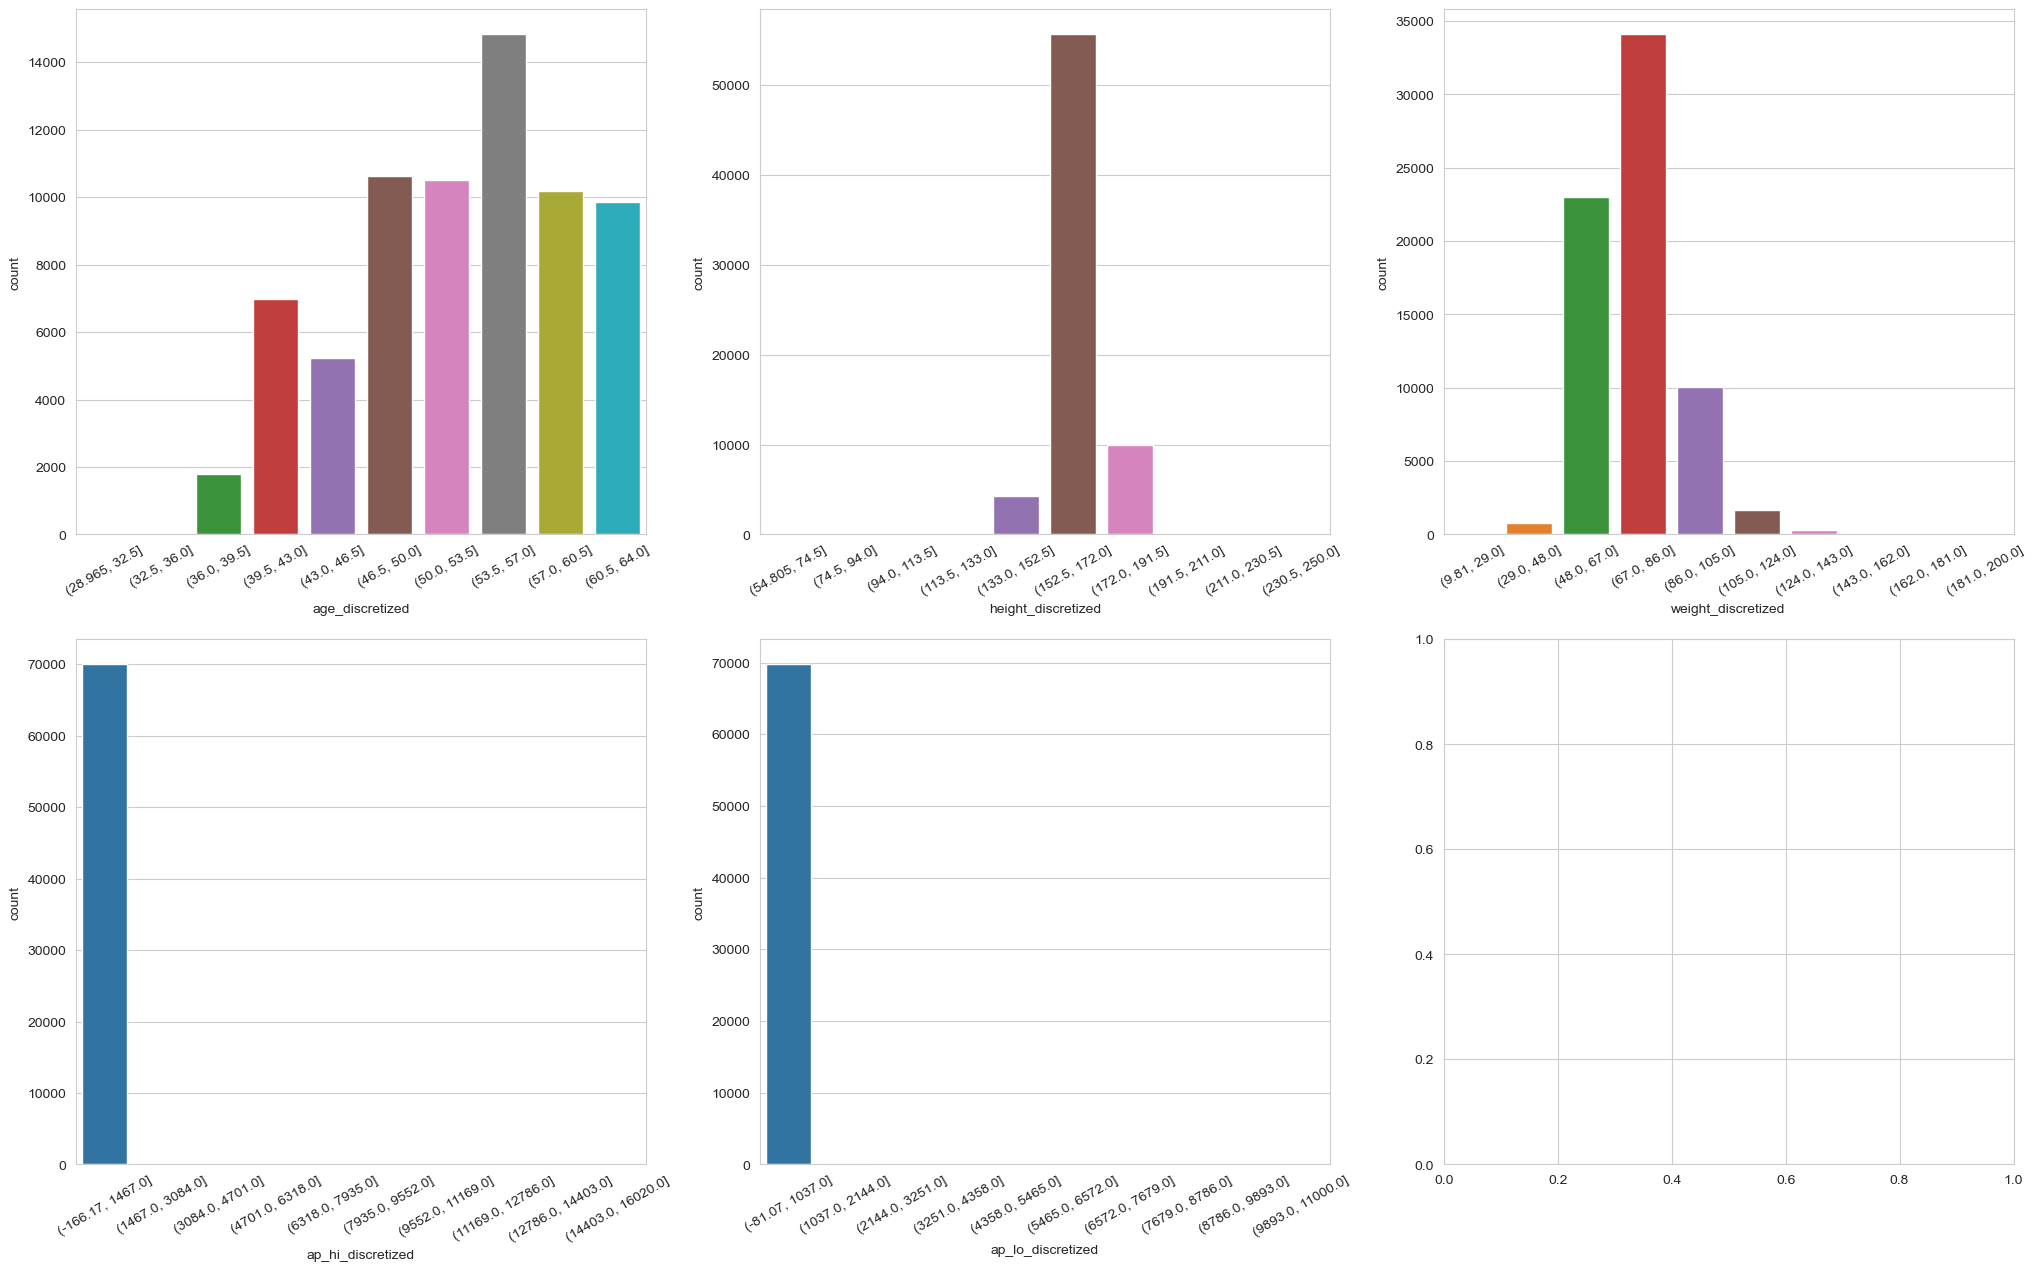

In [85]:
cat_cols = ["age_discretized", "height_discretized", "weight_discretized", "ap_hi_discretized", "ap_lo_discretized"]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 15))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    g = sns.countplot(x=col, data=dataset, ax=axes[i])
    axes[i].set_xlabel(col)
    g.set_xticklabels(g.get_xticklabels(), rotation=30)


In [ ]:
# Discretize the 'age' variable into 5 intervals based on quantiles
df['age_discretized'] = pd.qcut(df['age'], q=10)

# Discretize the 'height' variable into 3 intervals based on quantiles
df['height_discretized'] = pd.qcut(df['height'], q=10)

# Discretize the 'weight' variable into 4 intervals based on quantiles
df['weight_discretized'] = pd.qcut(df['weight'], q=10)
# Discretize the 'age' variable into 5 intervals
df['ap_hi_discretized'] = pd.qcut(df['ap_hi'],  q=3)

# Discretize the 'height' variable into 3 intervals
df['ap_lo_discretized'] = pd.qcut(df['ap_lo'],  q=2)

# Print the first 5 rows of the discretized dataset
df.head()


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio_disease,age_discretized,height_discretized,weight_discretized,ap_hi_discretized,ap_lo_discretized
0,0,50,2,168,62,110,80,1,1,0,0,1,0,"(49.0, 51.0]","(166.0, 168.0]","(58.0, 63.0]","(79.999, 120.0]","(59.999, 80.0]"
1,1,55,1,156,85,140,90,3,1,0,0,1,1,"(53.0, 55.0]","(155.0, 158.0]","(84.0, 92.0]","(130.0, 180.0]","(80.0, 110.0]"
2,2,51,1,165,64,130,70,3,1,0,0,0,1,"(49.0, 51.0]","(162.0, 165.0]","(63.0, 65.0]","(120.0, 130.0]","(59.999, 80.0]"
3,3,48,2,169,82,150,100,1,1,0,0,1,1,"(46.0, 49.0]","(168.0, 170.0]","(79.0, 84.0]","(130.0, 180.0]","(80.0, 110.0]"
4,4,47,1,156,56,100,60,1,1,0,0,0,0,"(46.0, 49.0]","(155.0, 158.0]","(30.999, 58.0]","(79.999, 120.0]","(59.999, 80.0]"


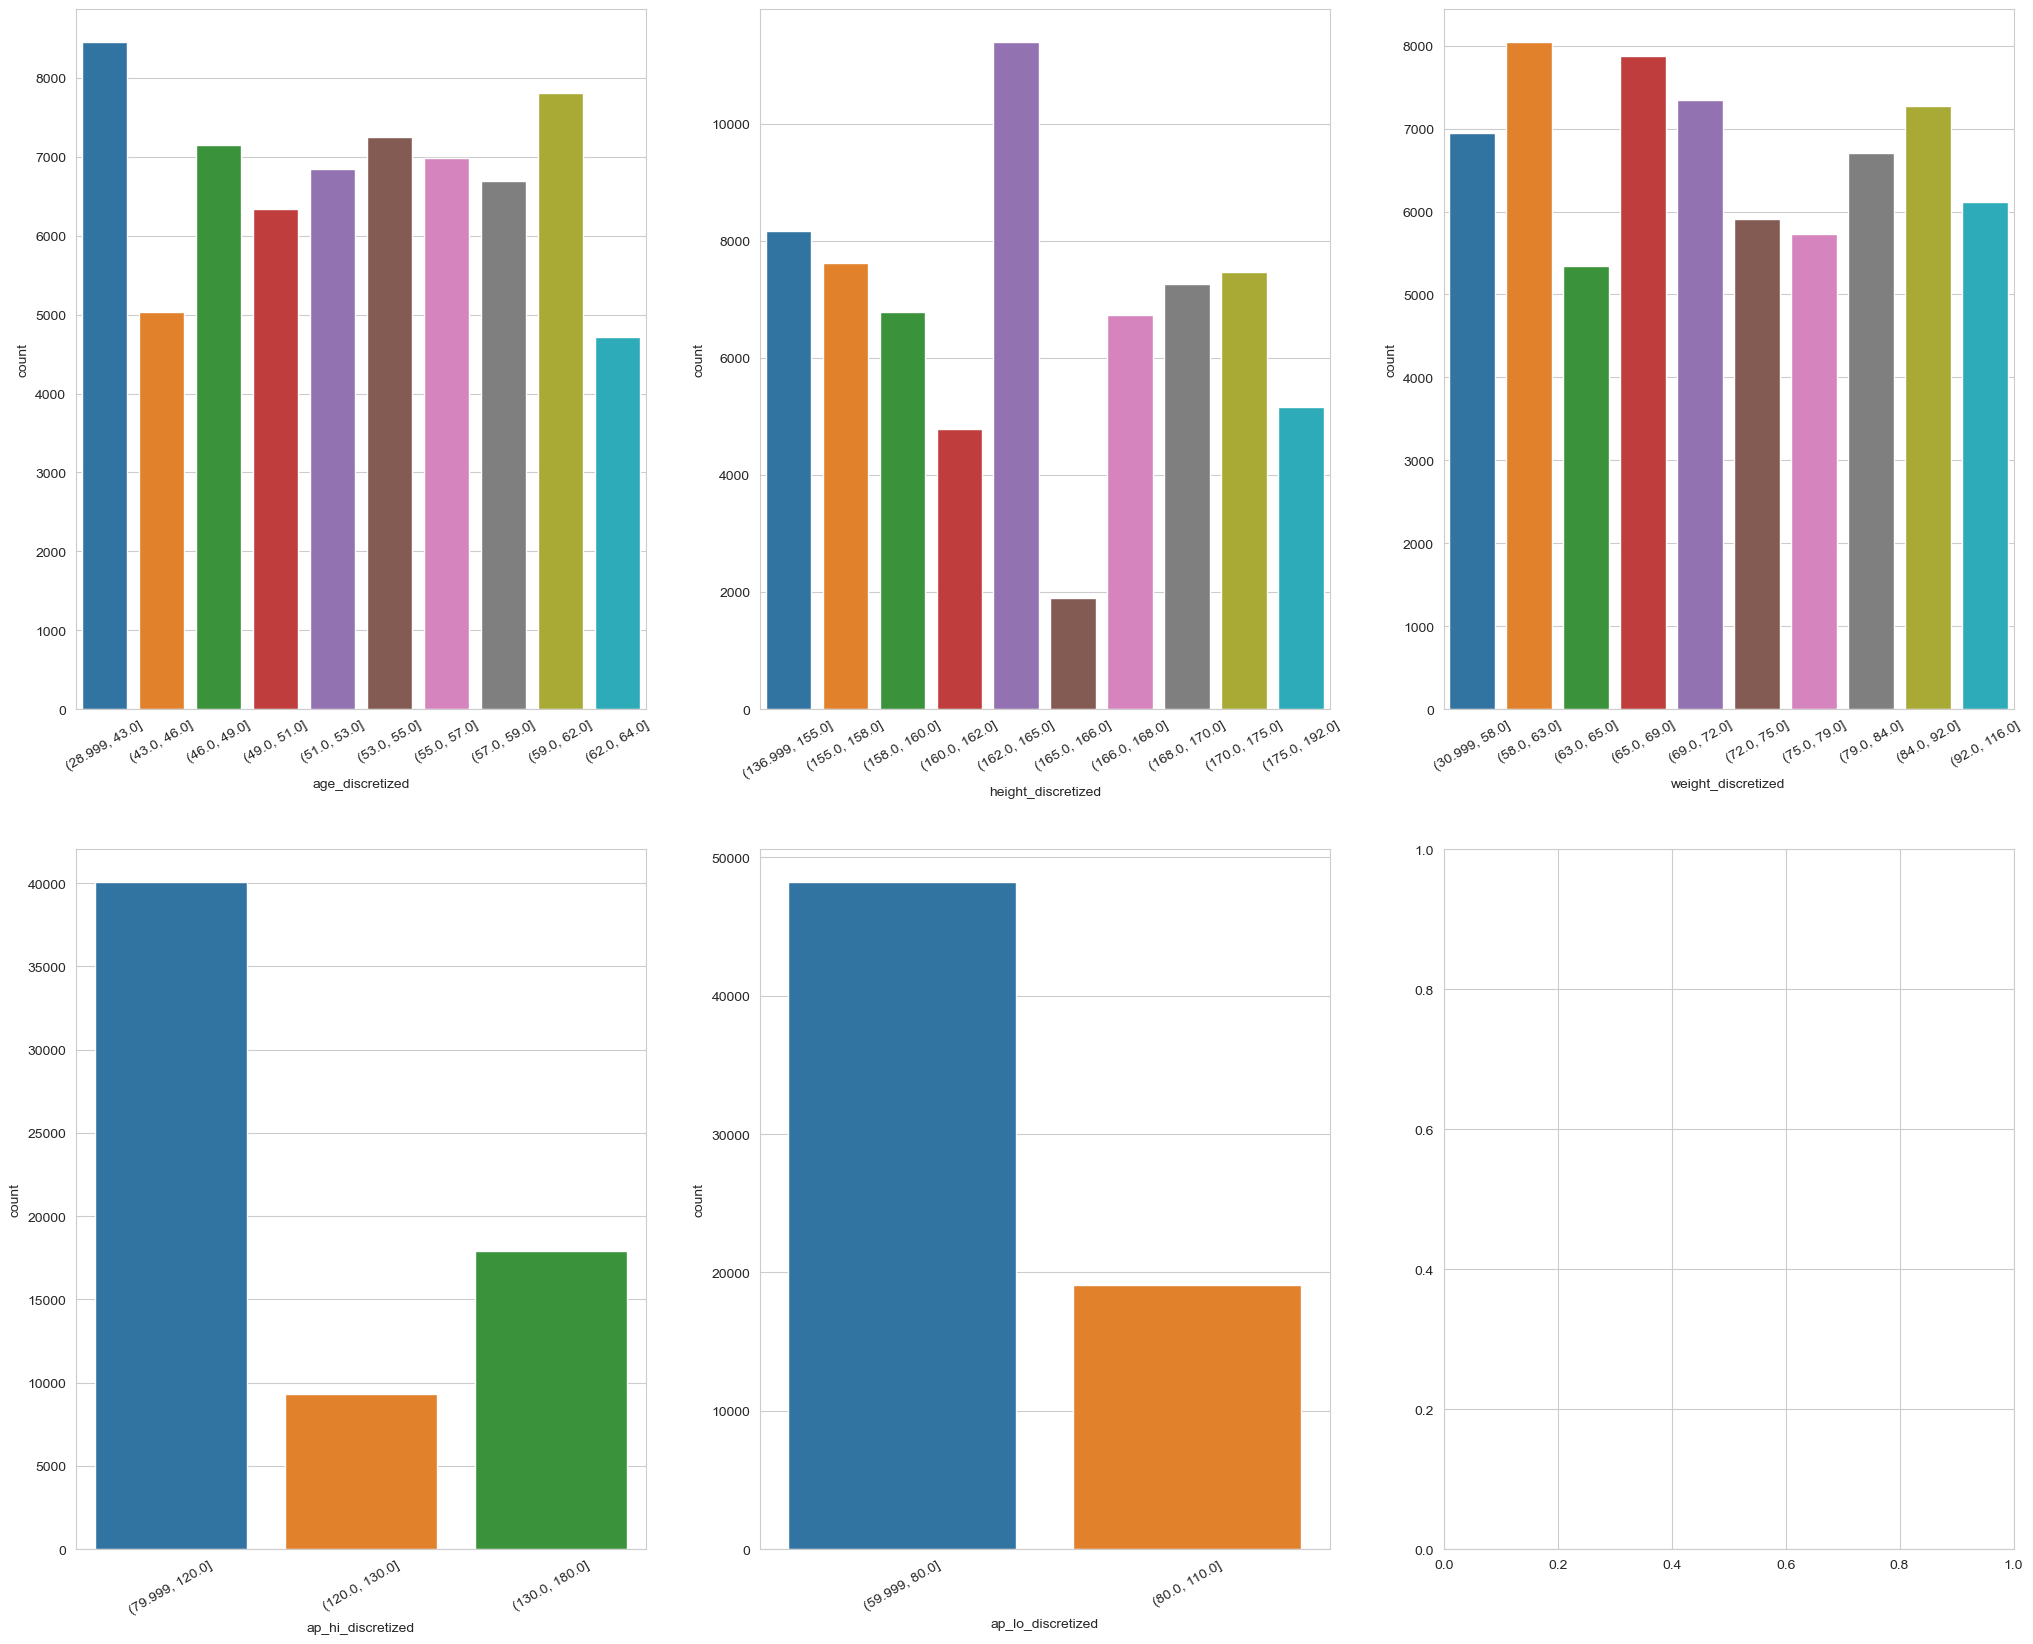

In [ ]:
cat_cols = ["age_discretized", "height_discretized", "weight_discretized", "ap_hi_discretized", "ap_lo_discretized"]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 20))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    g = sns.countplot(x=col, data=df, ax=axes[i])
    axes[i].set_xlabel(col)
    g.set_xticklabels(g.get_xticklabels(), rotation=30)

In [ ]:
df['age'] = pd.factorize(df['age_discretized'])[0]
df['height'] = pd.factorize(df['height_discretized'])[0]
df['weight'] = pd.factorize(df['weight_discretized'])[0]
df['ap_hi'] = pd.factorize(df['ap_hi_discretized'])[0]
df['ap_lo'] = pd.factorize(df['ap_lo_discretized'])[0]

df.drop(['age_discretized', 'height_discretized','weight_discretized', 'ap_hi_discretized','ap_lo_discretized'], axis=1, inplace=True)

df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio_disease
0,0,0,2,0,0,0,0,1,1,0,0,1,0
1,1,1,1,1,1,1,1,3,1,0,0,1,1
2,2,2,1,0,0,2,2,3,1,0,0,0,1
3,3,0,2,0,2,3,3,1,1,0,0,1,1
4,4,0,1,1,3,4,4,1,1,0,0,0,0


### Study Case 4 - HillClimbSearch vs MCMC with Outliers and Quantile Discretization

##### Discretize

In [9]:
# Discretize the 'age' variable into 5 intervals
df['age_discretized'] = pd.cut(df['age'], bins=10)

# Discretize the 'height' variable into 3 intervals
df['height_discretized'] = pd.cut(df['height'], bins=10)

# Discretize the 'weight' variable into 4 intervals
df['weight_discretized'] = pd.cut(df['weight'], bins=10)

# Discretize the 'age' variable into 5 intervals
df['ap_hi_discretized'] = pd.cut(df['ap_hi'], bins=10)

# Discretize the 'height' variable into 3 intervals
df['ap_lo_discretized'] = pd.cut(df['ap_lo'], bins=10)

# Print the first 5 rows of the discretized dataset
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio_disease,age_discretized,height_discretized,weight_discretized,ap_hi_discretized,ap_lo_discretized
0,0,50,2,168,62,110,80,1,1,0,0,1,0,"(46.5, 50.0]","(164.5, 170.0]","(56.5, 65.0]","(100.0, 110.0]","(75.0, 80.0]"
1,1,55,1,156,85,140,90,3,1,0,0,1,1,"(53.5, 57.0]","(153.5, 159.0]","(82.0, 90.5]","(130.0, 140.0]","(85.0, 90.0]"
2,2,51,1,165,64,130,70,3,1,0,0,0,1,"(50.0, 53.5]","(164.5, 170.0]","(56.5, 65.0]","(120.0, 130.0]","(65.0, 70.0]"
3,3,48,2,169,82,150,100,1,1,0,0,1,1,"(46.5, 50.0]","(164.5, 170.0]","(73.5, 82.0]","(140.0, 150.0]","(95.0, 100.0]"
4,4,47,1,156,56,100,60,1,1,0,0,0,0,"(46.5, 50.0]","(153.5, 159.0]","(48.0, 56.5]","(90.0, 100.0]","(59.95, 65.0]"


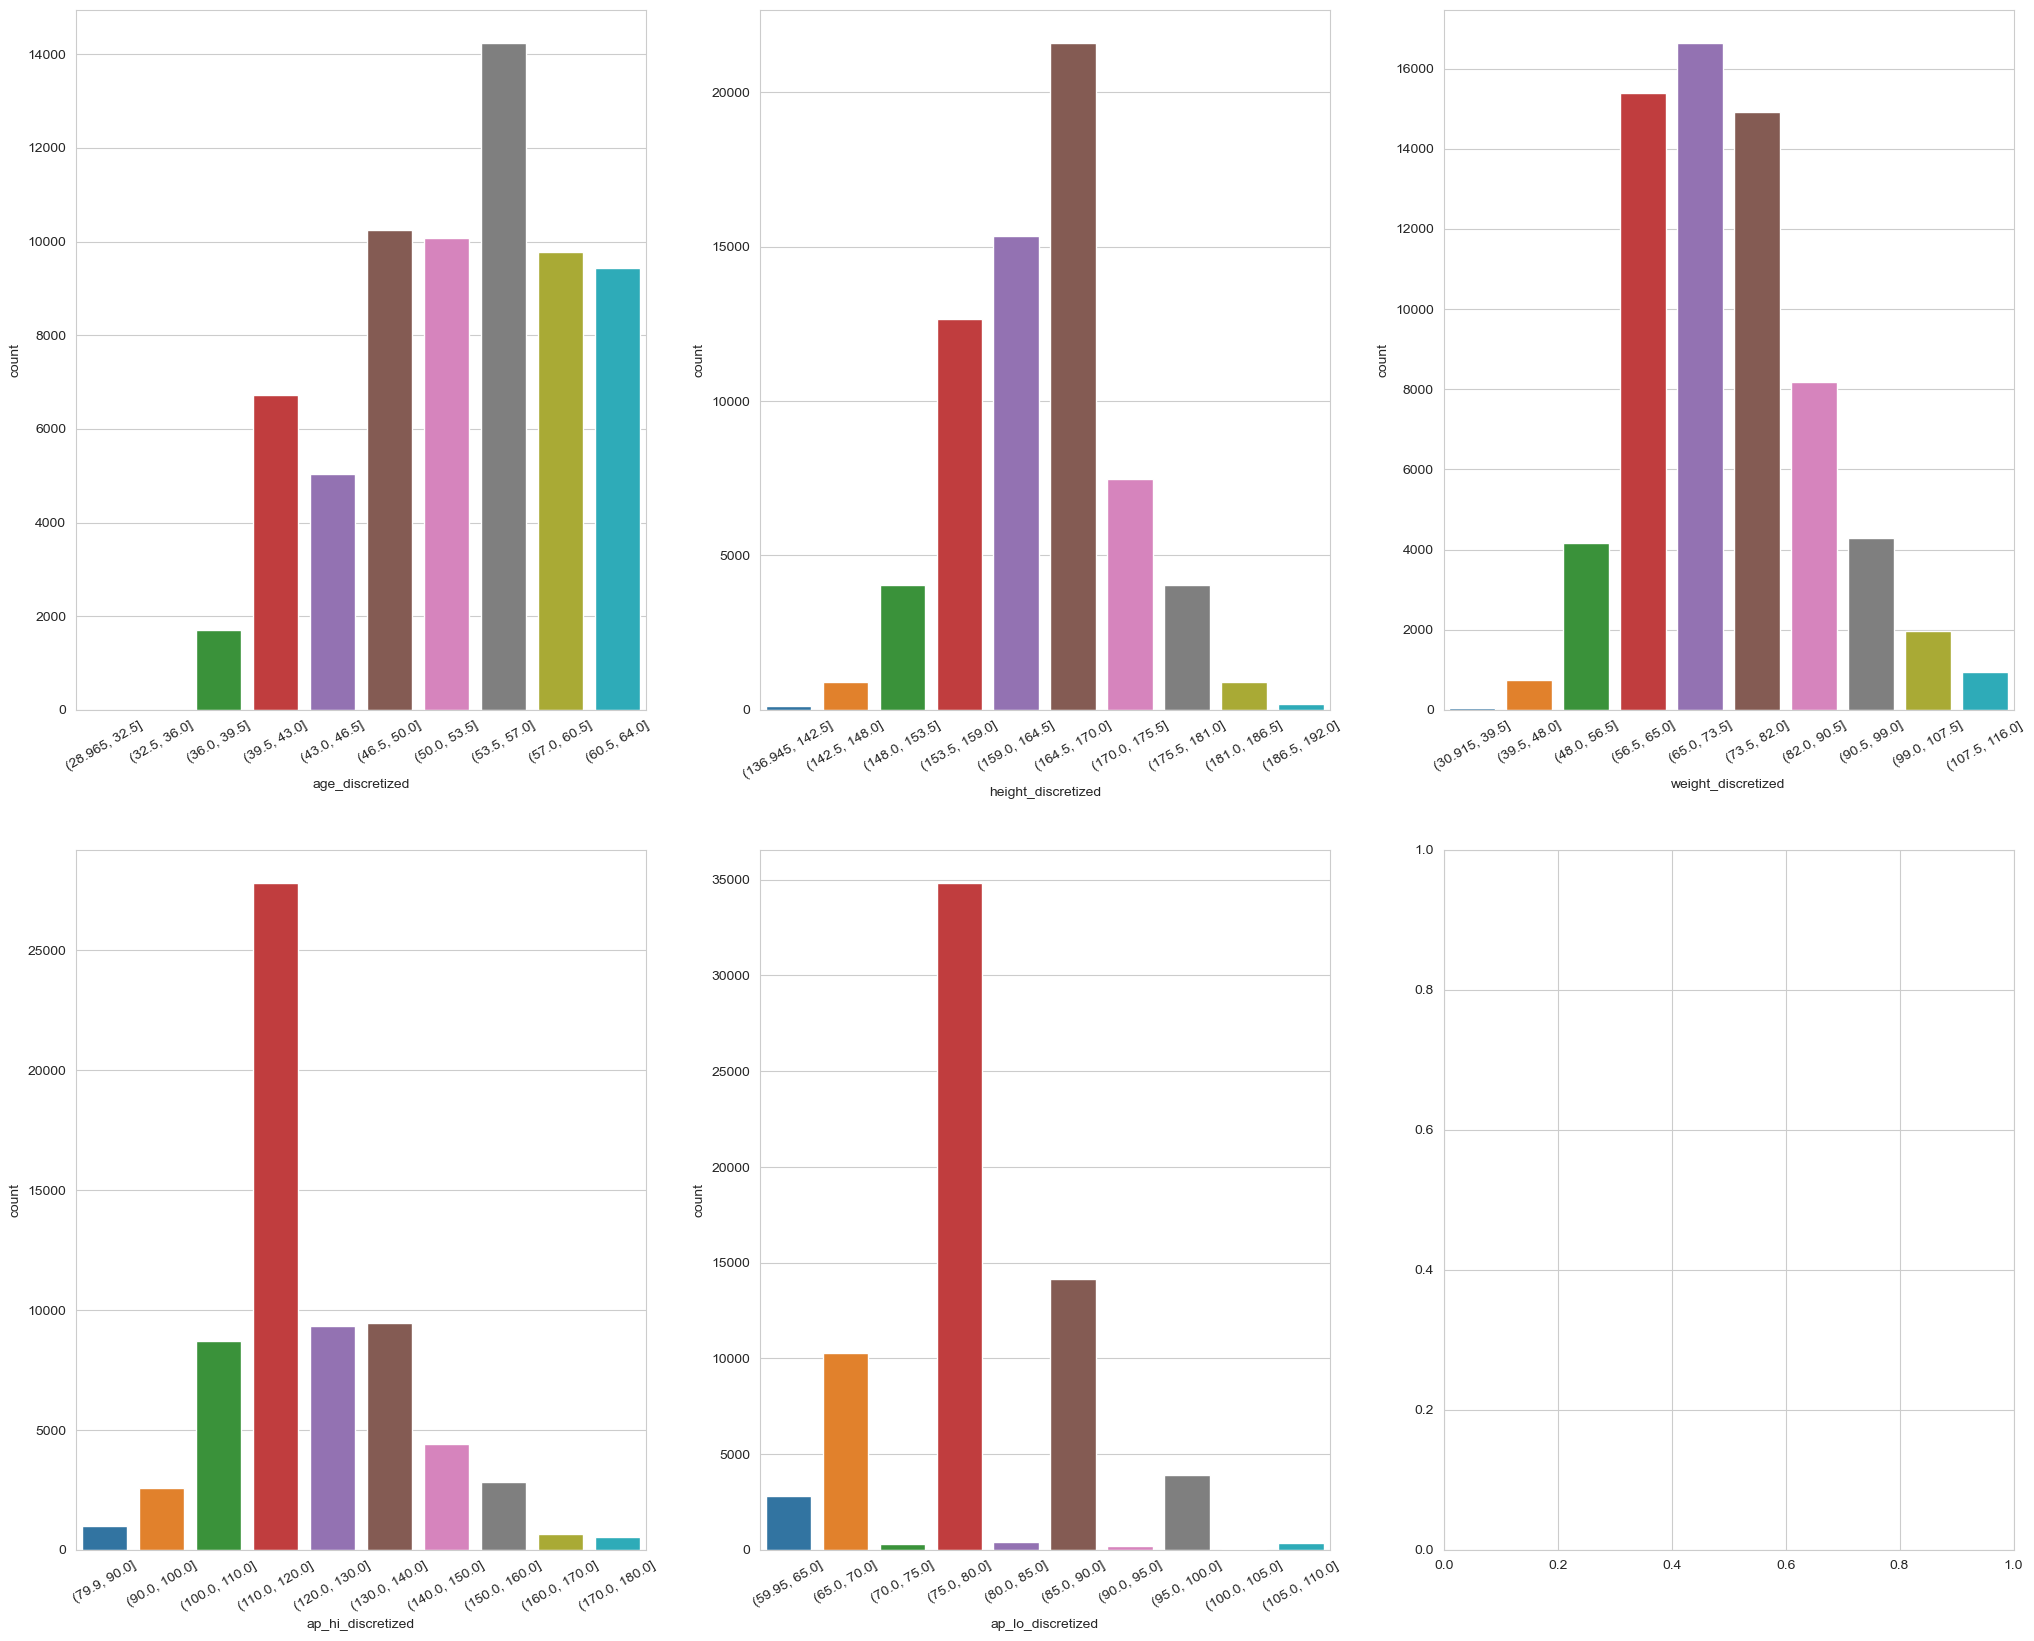

In [10]:
cat_cols = ["age_discretized", "height_discretized", "weight_discretized", "ap_hi_discretized", "ap_lo_discretized"]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 20))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    g = sns.countplot(x=col, data=df, ax=axes[i])
    axes[i].set_xlabel(col)
    g.set_xticklabels(g.get_xticklabels(), rotation=30)


In [13]:
# Discretize the 'age' variable into 5 intervals based on quantiles
df['age_discretized'] = pd.qcut(df['age'], q=10)

# Discretize the 'height' variable into 3 intervals based on quantiles
df['height_discretized'] = pd.qcut(df['height'], q=10)

# Discretize the 'weight' variable into 4 intervals based on quantiles
df['weight_discretized'] = pd.qcut(df['weight'], q=10)
# Discretize the 'age' variable into 5 intervals
df['ap_hi_discretized'] = pd.qcut(df['ap_hi'],  q=3)

# Discretize the 'height' variable into 3 intervals
df['ap_lo_discretized'] = pd.qcut(df['ap_lo'],  q=2)

# Print the first 5 rows of the discretized dataset
df.head()


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio_disease,age_discretized,height_discretized,weight_discretized,ap_hi_discretized,ap_lo_discretized
0,0,50,2,168,62,110,80,1,1,0,0,1,0,"(49.0, 51.0]","(166.0, 168.0]","(58.0, 63.0]","(79.999, 120.0]","(59.999, 80.0]"
1,1,55,1,156,85,140,90,3,1,0,0,1,1,"(53.0, 55.0]","(155.0, 158.0]","(84.0, 92.0]","(130.0, 180.0]","(80.0, 110.0]"
2,2,51,1,165,64,130,70,3,1,0,0,0,1,"(49.0, 51.0]","(162.0, 165.0]","(63.0, 65.0]","(120.0, 130.0]","(59.999, 80.0]"
3,3,48,2,169,82,150,100,1,1,0,0,1,1,"(46.0, 49.0]","(168.0, 170.0]","(79.0, 84.0]","(130.0, 180.0]","(80.0, 110.0]"
4,4,47,1,156,56,100,60,1,1,0,0,0,0,"(46.0, 49.0]","(155.0, 158.0]","(30.999, 58.0]","(79.999, 120.0]","(59.999, 80.0]"


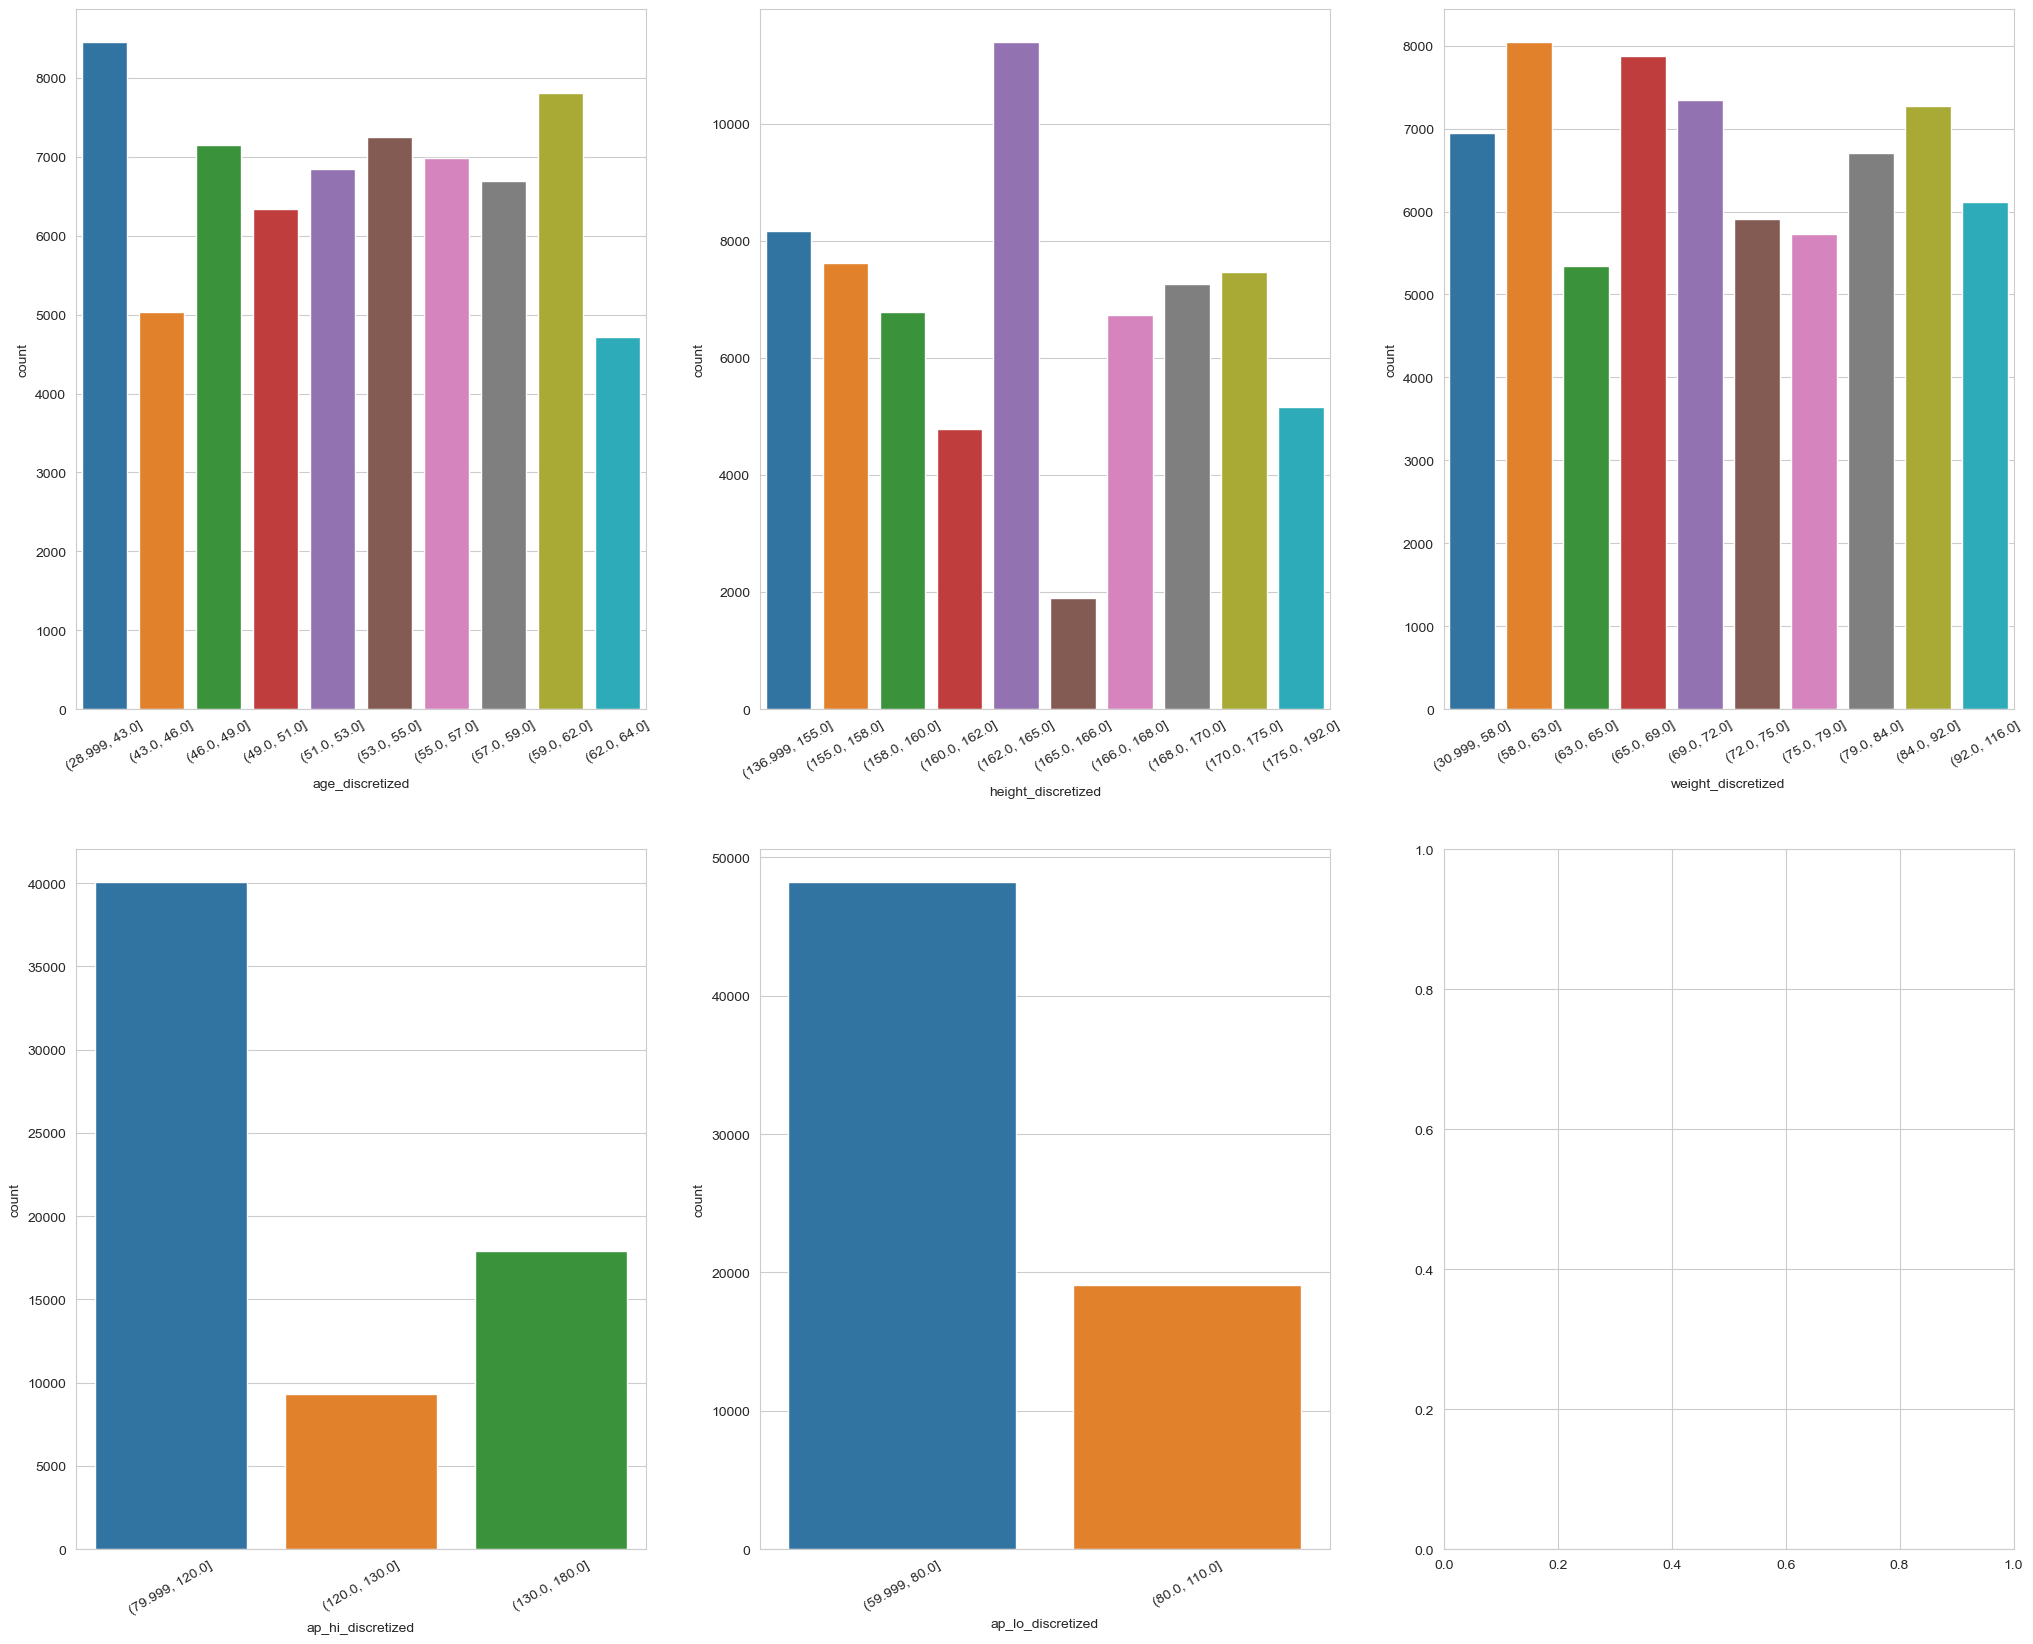

In [14]:
cat_cols = ["age_discretized", "height_discretized", "weight_discretized", "ap_hi_discretized", "ap_lo_discretized"]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 20))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    g = sns.countplot(x=col, data=df, ax=axes[i])
    axes[i].set_xlabel(col)
    g.set_xticklabels(g.get_xticklabels(), rotation=30)

In [11]:
df['age'] = pd.factorize(df['age_discretized'])[0]
df['height'] = pd.factorize(df['height_discretized'])[0]
df['weight'] = pd.factorize(df['weight_discretized'])[0]
df['ap_hi'] = pd.factorize(df['ap_hi_discretized'])[0]
df['ap_lo'] = pd.factorize(df['ap_lo_discretized'])[0]

df.drop(['age_discretized', 'height_discretized','weight_discretized', 'ap_hi_discretized','ap_lo_discretized'], axis=1, inplace=True)

df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio_disease
0,0,0,2,0,0,0,0,1,1,0,0,1,0
1,1,1,1,1,1,1,1,3,1,0,0,1,1
2,2,2,1,0,0,2,2,3,1,0,0,0,1
3,3,0,2,0,2,3,3,1,1,0,0,1,1
4,4,0,1,1,3,4,4,1,1,0,0,0,0


### Output and Test